In [128]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

This is a three layer Neural Network that will fit any numerical function. Currently fitting a noisy parabola

In [129]:
#generate data

h = 1e-6 #Used in the derivative function to increment weights and biases

numExamples = 1000 #number of training Examples
numFeatures = 1   #number of features

#creates feature matrix
f = np.zeros((numFeatures, numExamples))
f[0, :] = np.linspace(-10, 10, numExamples)

#creates noise with variance of 20%
noise = np.random.randn(numExamples)/5

#creates label vector
l = 0.1*(f[0]-0)**2

#Adds noise to labels
noisyLabels = l*(1+noise)

#number of nodes in each layer. 
#currently multiple layers is not working properly so I have disabled it. Changing last two number will have no effect.
#First number is basically how many max (relu) functions to use in fit
numNodes = np.array([2, 5, 1])

#Initial training Weights. Intialized randomly with a normal distribution
w = np.zeros(3,dtype = object)

w[0] = np.random.normal(0, 1/numFeatures**0.5, (numNodes[0], numFeatures))
w[1] = np.random.normal(0, 1/numNodes[0]**0.5, (numNodes[1], numNodes[0]))
w[2] = np.random.normal(0, 1/numNodes[1]**0.5, (numNodes[2], numNodes[1]))


#Initial training Weights. Intialized randomly with a normal distribution
b = np.zeros(3,dtype=object)
b[0] = np.random.normal(0, 1, numNodes[0])
b[1] = np.random.normal(0, 1, numNodes[1])
b[2] = np.random.normal(0, 1, numNodes[2])

<IPython.core.display.Javascript object>


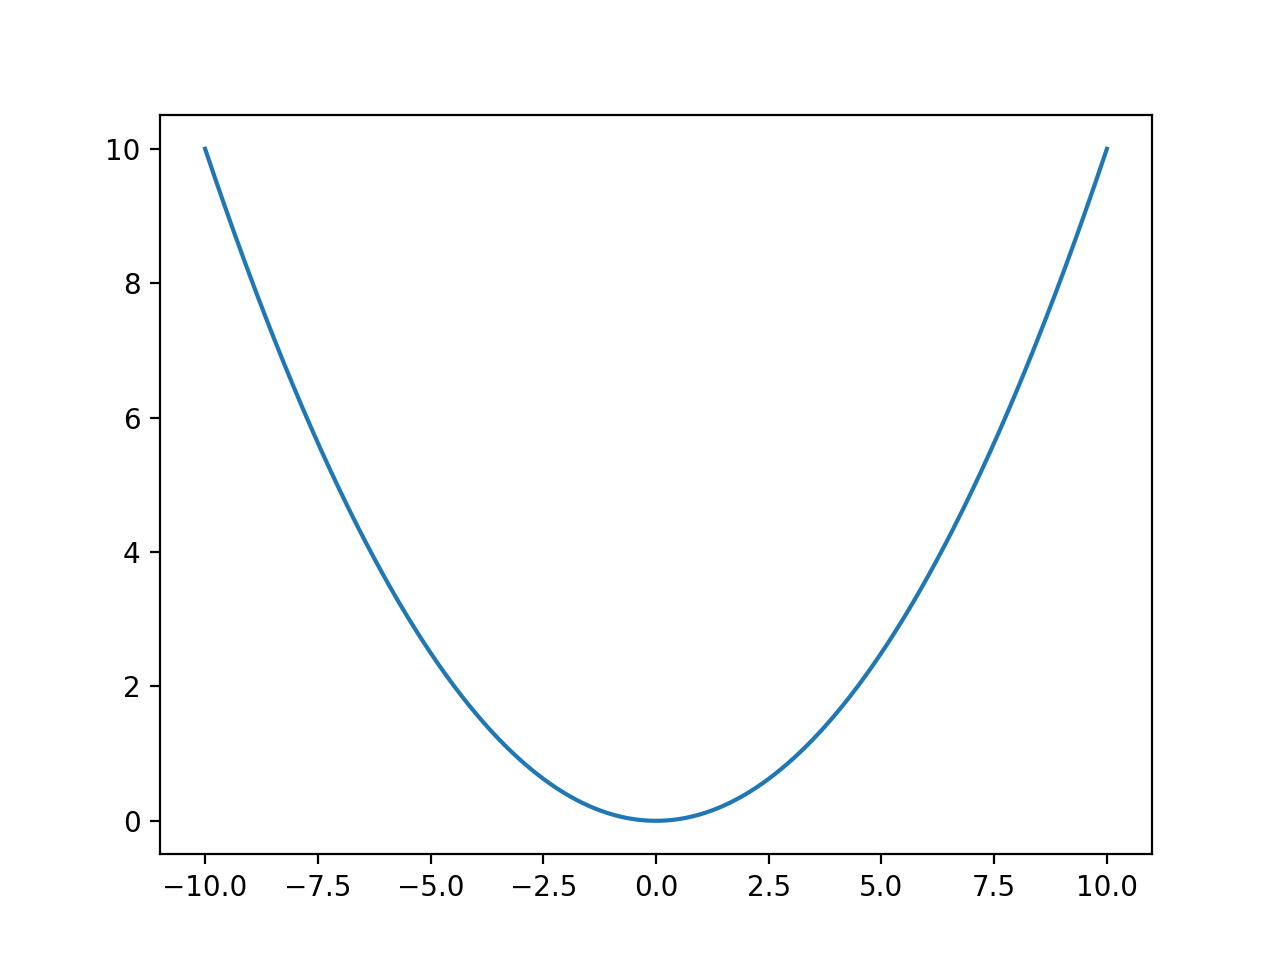

In [130]:
#Plot of features and true labels
plt.figure()
plt.plot(np.ravel(f),l)
plt.show()

<IPython.core.display.Javascript object>


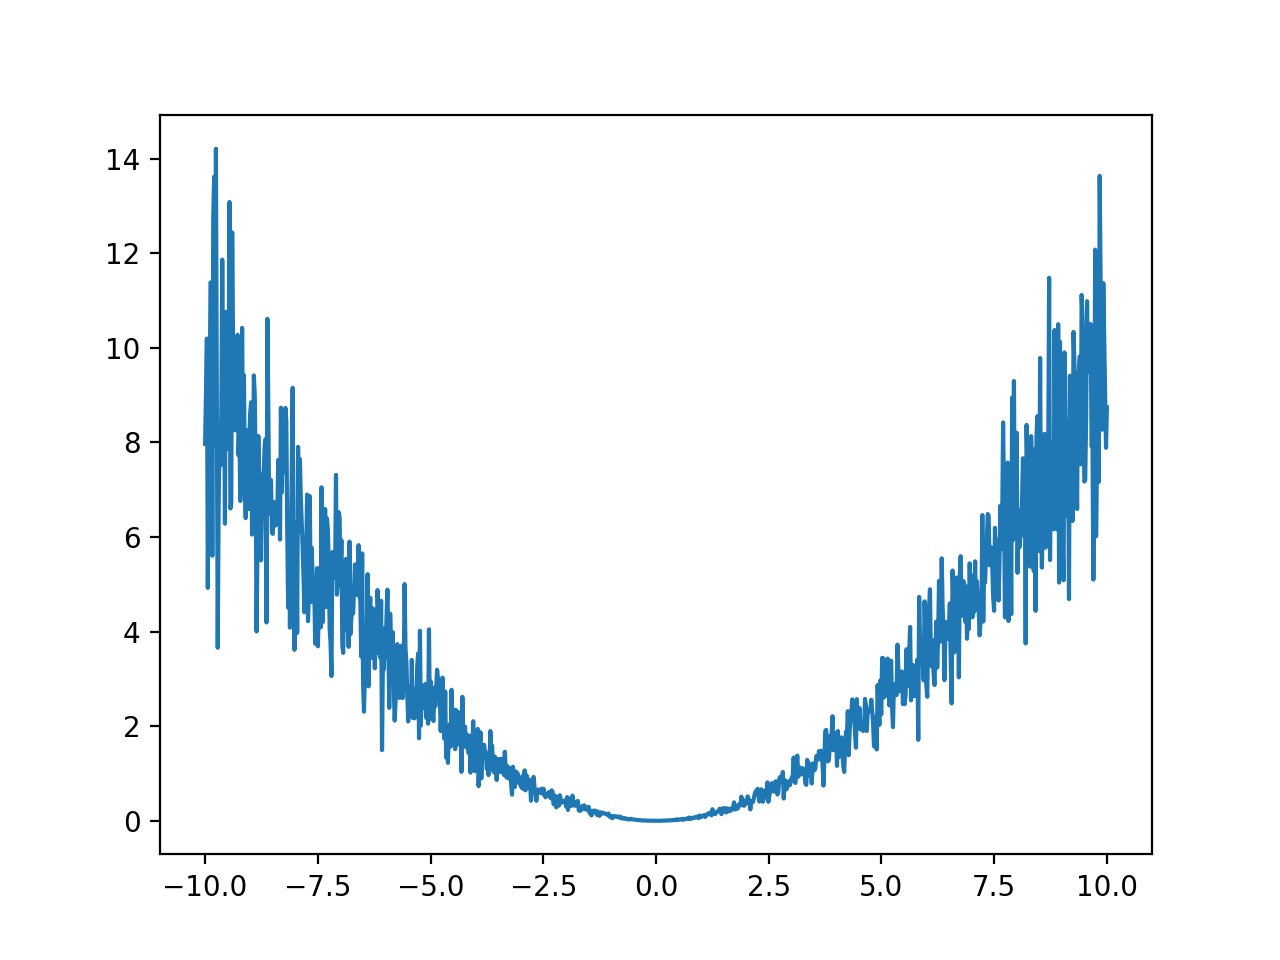

In [131]:
#Plot of features and noisy labels
plt.figure()
plt.plot(np.ravel(f),noisyLabels)
plt.show()

#One layer prediction
#for debugging
#Skips over the computation of the second two layers. Used to debug program

def predict(w,f,b):
    L1 = np.maximum(np.dot(w[0], f) + b[0][:,None],0)

    #print("w0 is {}. b0 is {}. w1 is {}. b1 is {}. w2 is {}. b2 is {}. L1 is {}. L2 is {}. L3 is {}".format(w[0], b[0], w[1], b[1], w[2], b[2], L1, L2, L3))
    return np.sum(L1,axis = 0)

#2 layer prediction
#for debugging
def predict(w,f,b):
    L1 = np.arctan(np.dot(w[0], f) + np.transpose(np.tile(b[0], (numExamples, 1))))
    L2 = np.dot(w[1], L1) + np.transpose(np.tile(b[1], (numExamples, 1)))
    #L3 = np.dot(w[2], L2) + np.transpose(np.tile(b[2], (numExamples, 1)))
    #print("w0 is {}. b0 is {}. w1 is {}. b1 is {}. w2 is {}. b2 is {}. L1 is {}. L2 is {}. L3 is {}".format(w[0], b[0], w[1], b[1], w[2], b[2], L1, L2, L3))
    return L2

In [132]:
#Three layer prediction. Predicts a label for a given feature vector, weights, and biases using arctan functions.
def predict(w,f,b):
    #dot product of weights and features + a bias with an arctan non-linearity
    L1 = np.arctan(np.dot(w[0], f) + np.transpose(np.tile(b[0], (numExamples, 1))))
    #dot product of weights and features + a bias with an arctan non-linearity
    L2 = np.arctan(np.dot(w[1], L1) + np.transpose(np.tile(b[1], (numExamples, 1))))
    #dot product of weights and features + a bias. No non-linearity on final layer
    L3 = np.dot(w[2], L2) + np.transpose(np.tile(b[2], (numExamples, 1)))
    return L3

In [133]:
#Sum of the squared error over all training examples with specific weights and biases

def error(l,w,f,b):
    return np.sum((predict(w,f,b) - l)**2)

In [134]:
#Gets derivative of weights and biases with respect to error

def derivative(l, w, f, b):
    
    #Initializes weight derivative and bias deriviative matrices
    dw = np.zeros(3,dtype = object)
    dw[0] = np.zeros( (numNodes[0] , numFeatures) )
    dw[1] = np.zeros( (numNodes[1] , numNodes[0]) )
    dw[2] = np.zeros( (numNodes[2] , numNodes[1]) )

    db = np.zeros(3,dtype=object)
    db[0] = np.zeros(numNodes[0])
    db[1] = np.zeros(numNodes[1])
    db[2] = np.zeros(numNodes[2])
    
    #Error of current weights and biases with no h incrementation. Used to cut down computation time
    SSE = error(l, w, f, b)
    
    #Calculates derivative of the error with respect to each weight and creates a gradient
    for i in range(dw.shape[0]):
        for j in range(dw[i].shape[0]):
            for k in range(dw[i][j].shape[0]): 
                w[i][j][k] += h
                dw[i][j][k] = (error(l, w, f, b) - SSE) / h #Uses definition of derivative
                w[i][j][k] -= h

    #Calculates derivative of error with respect to each bias and creates a gradient                  
    for i in range(db.shape[0]):
        for j in range(db[i].shape[0]):
                b[i][j] += h
                db[i][j] = (error(l, w, f, b) - SSE) / h #Uses definition of derivative
                e = error(l, w, f, b)
                #print("err: {}. SSE:{}".format(e,SSE))
                b[i][j] -= h

    return dw,db

<IPython.core.display.Javascript object>


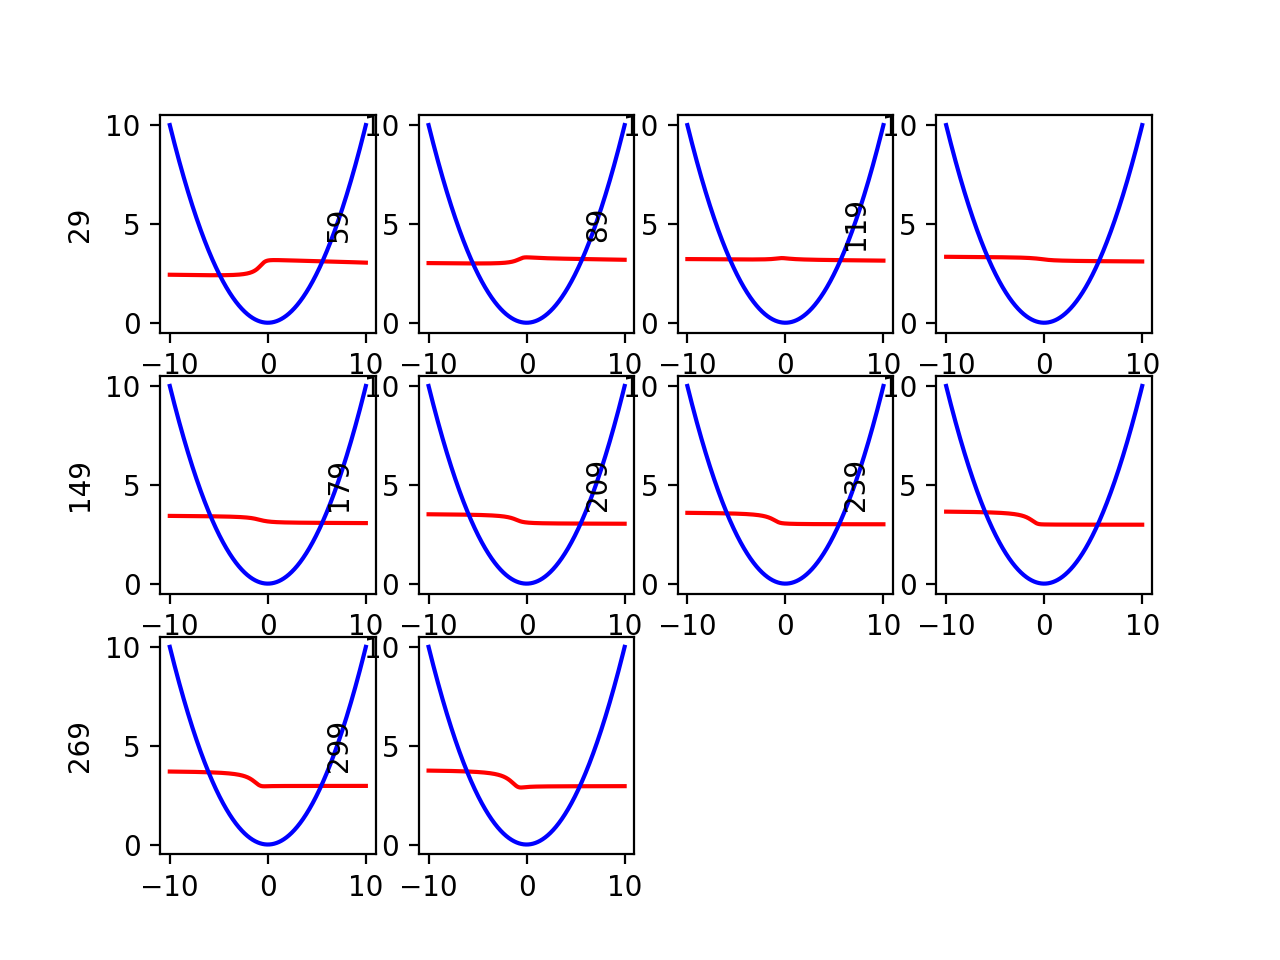

<IPython.core.display.Javascript object>


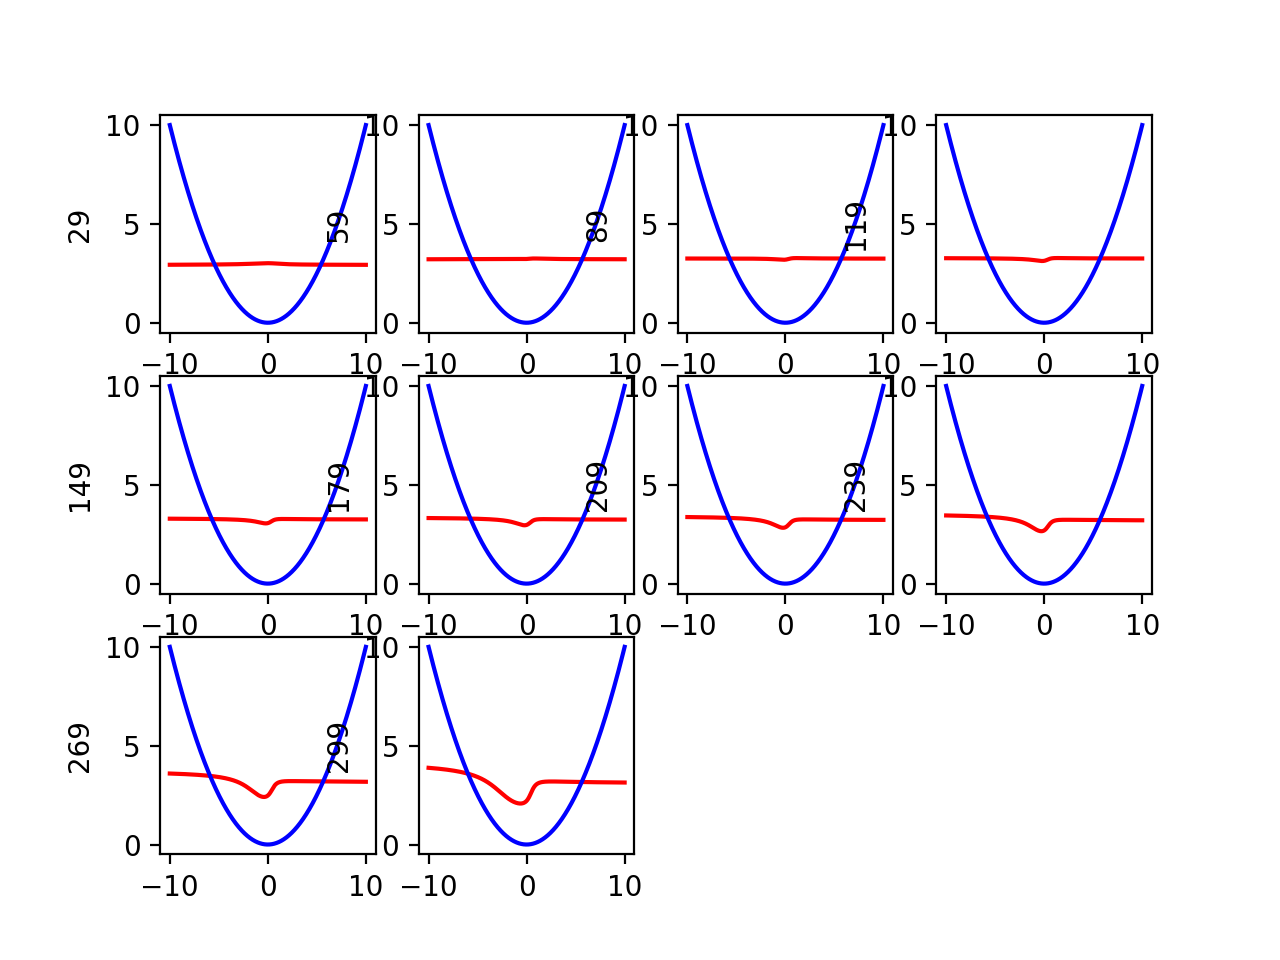

<IPython.core.display.Javascript object>


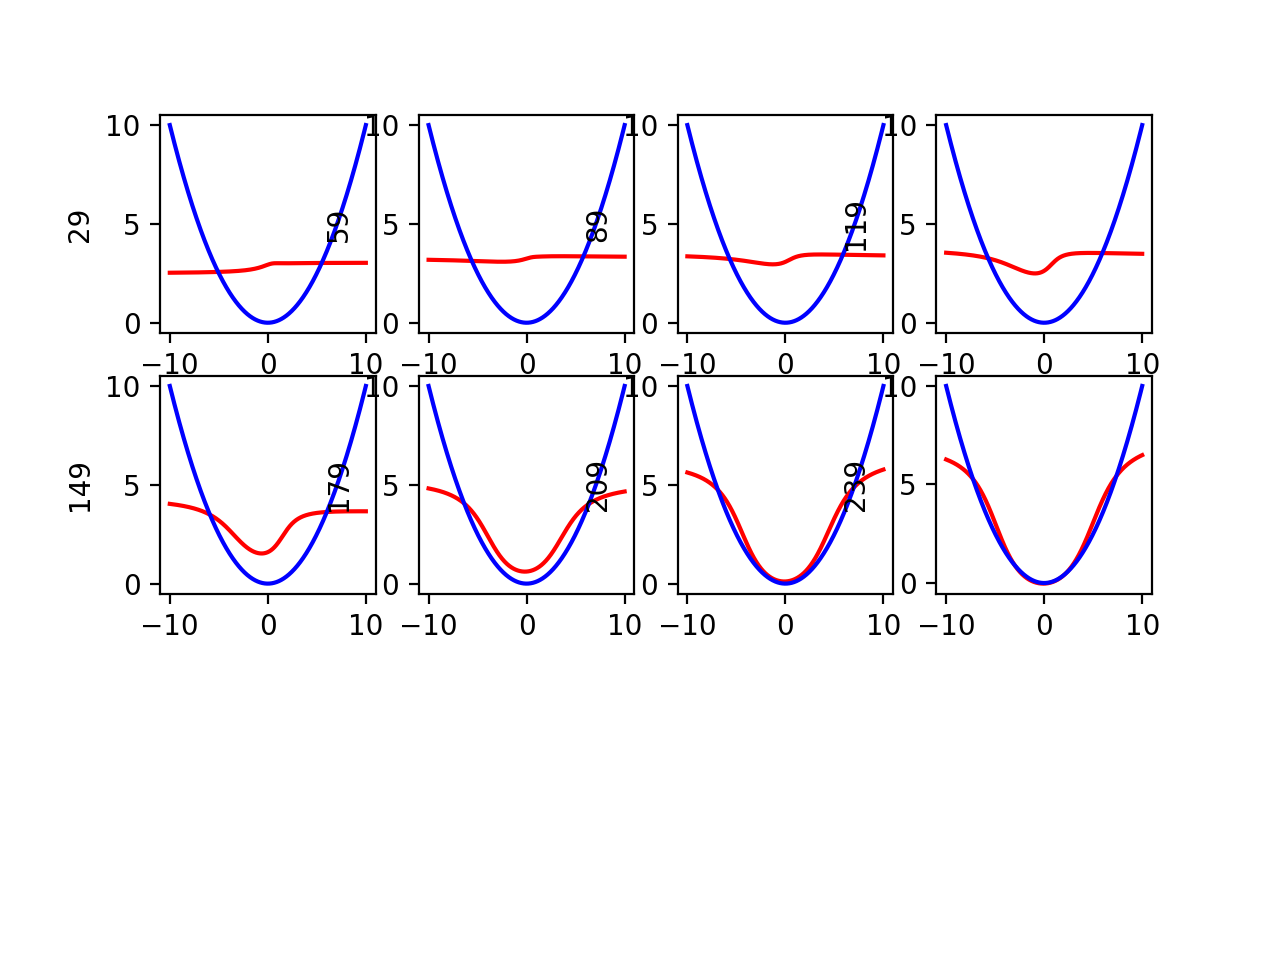

trained for 251 epochs


<IPython.core.display.Javascript object>


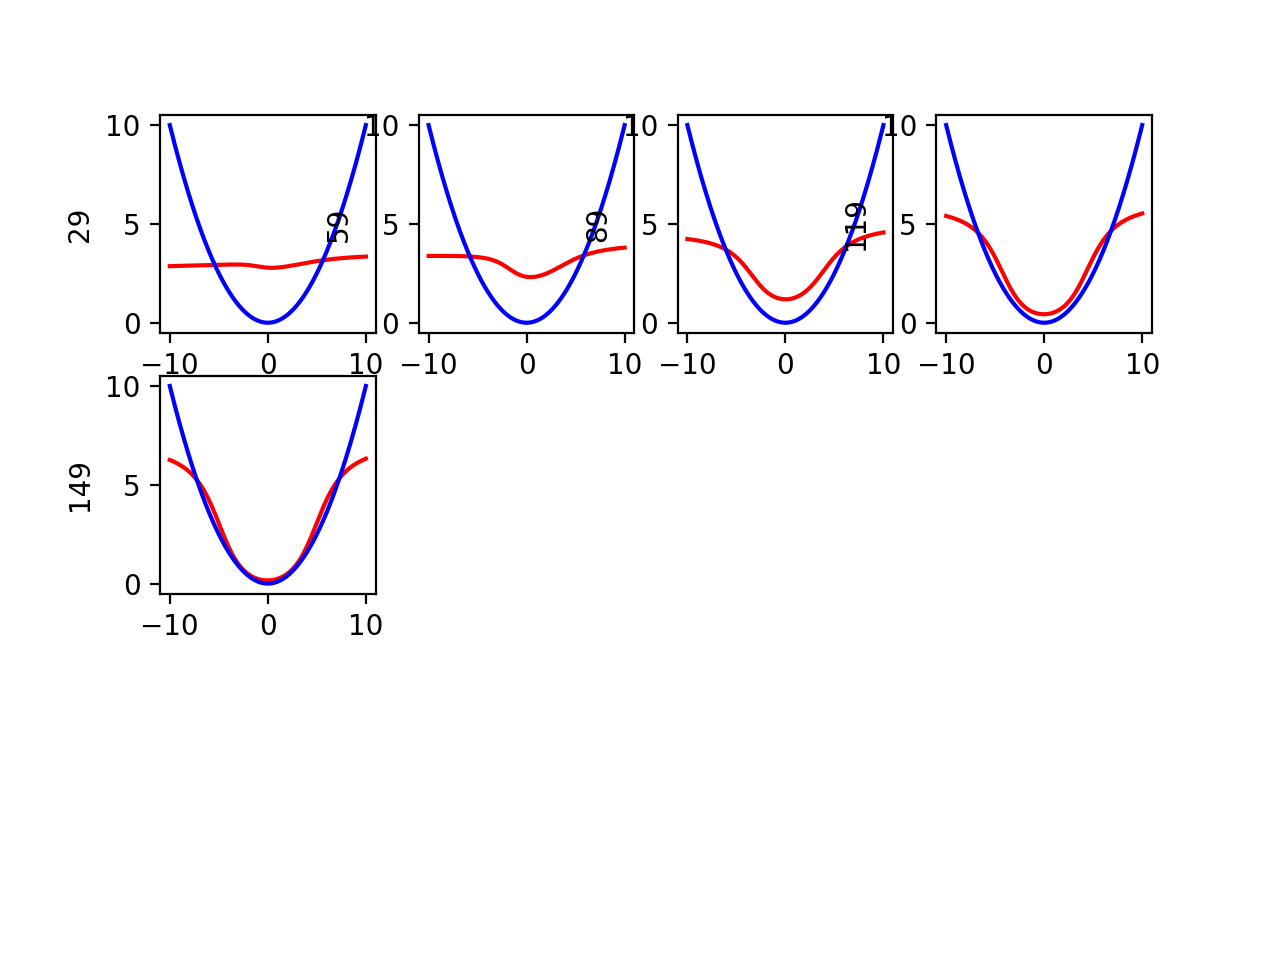

trained for 167 epochs


<IPython.core.display.Javascript object>


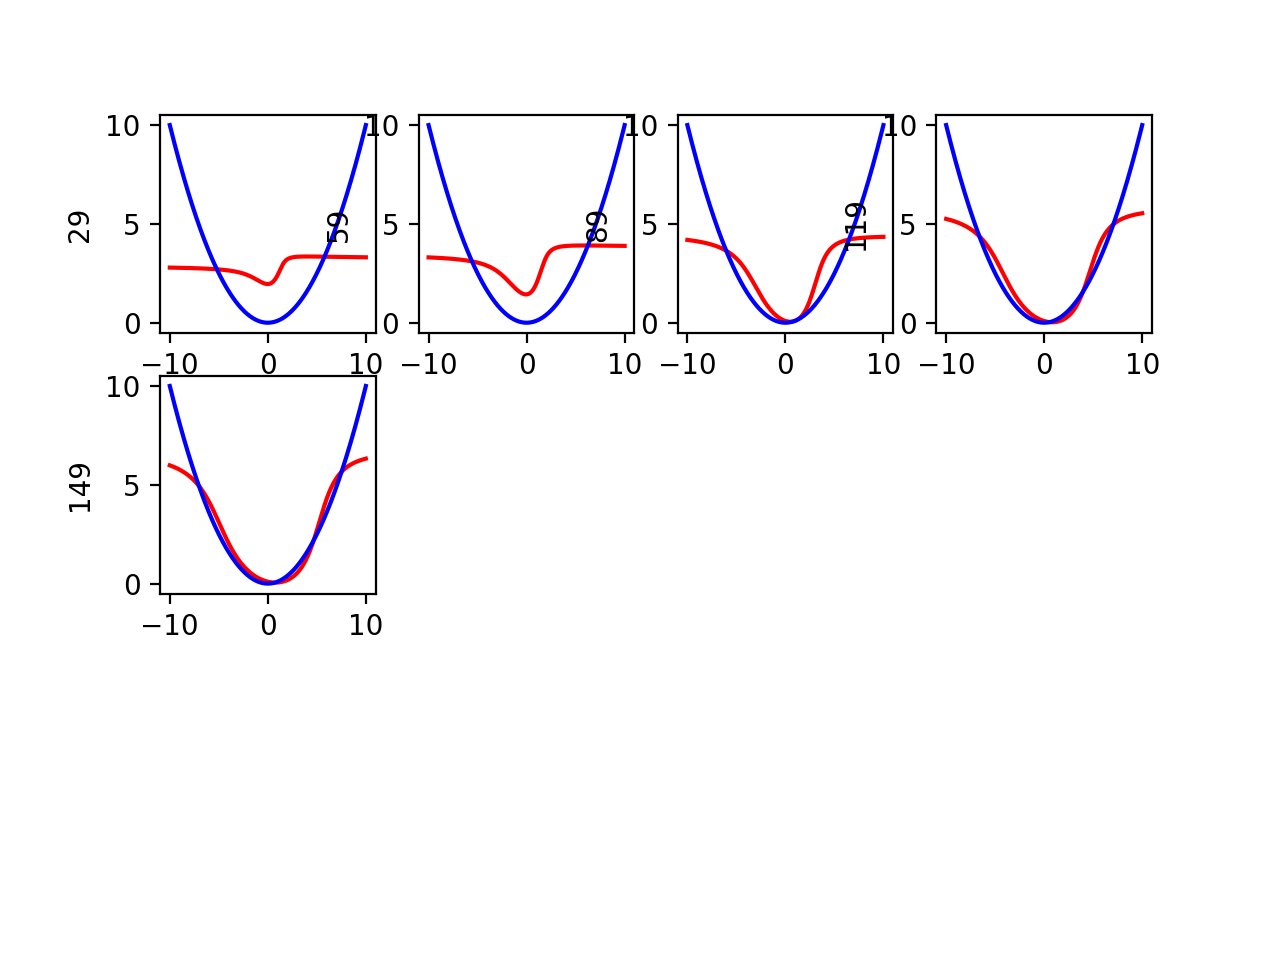

trained for 160 epochs


In [135]:

wGain = 1e-5 #Gain for weight incrementation (learning rate). Might need to be tweaked if number of nodes is changed
bGain = 1e-5 #Gain for bias incrementation (learning rate). Might need to be tweaked if number of nodes is changed

#Initializes weights randomly 5 times and trains on them. Program then returns the best final weights.
#This decreases the likelyhood of returning a local minima caused by bad weight initialization.

epochs = 300 #Number of training cycles

allWeights = np.zeros(5, dtype = object) #Stores all weights
allBiases = np.zeros(5, dtype = object) #Stores all biases

#Stores error progression from training with each different weight initialization
allErrors = np.zeros((5,epochs)) 

for j in range(5):
    
    #Initial training Weights. Intialized randomly with a normal distribution
    w = np.zeros(3,dtype = object)

    w[0] = np.random.normal(0, 1/numFeatures**0.5, (numNodes[0], numFeatures))
    w[1] = np.random.normal(0, 1/numNodes[0]**0.5, (numNodes[1], numNodes[0]))
    w[2] = np.random.normal(0, 1/numNodes[1]**0.5, (numNodes[2], numNodes[1]))

    #Initial training Biases. Intialized randomly with a normal distribution
    b = np.zeros(3,dtype=object)
    b[0] = np.random.normal(0, 1, numNodes[0])
    b[1] = np.random.normal(0, 1, numNodes[1])
    b[2] = np.random.normal(0, 1, numNodes[2])

    #Stores derivatives at every epoch
    derivatives = np.zeros(epochs, dtype = object)

    #Stores error at every training cycle
    errors = np.zeros(epochs)

    plotCounter = 1 #Keeps track of current subplot
    plt.figure()
    for i in range(epochs):
        dw,db = derivative(noisyLabels, w, f, b) #Calculates derivative of current weight and bias matrices
        w -= dw*wGain #Increments weights by multiplying by wGain
        b -= db*bGain #Increments biases by multiplying by bGain
        derivatives[i] = dw #Stores derivative of the current cycle
        errors[i] = error(noisyLabels, w, f, b) #Stores current error
        if i%(epochs/10) == (epochs / 10) - 1:
            #Plots what the current fit function is every 30 epochs. Number to the left of plot is epoch
            #Shows the evolution of the fit function
            relus = np.zeros(w[0].shape)
            relus = np.maximum(f*w[0]+b[0][:,None],0)
            p = predict(w, f, b)
            plt.subplot(3,4,plotCounter)
            plt.plot(f[0], np.ravel(p), "r-", f[0], np.ravel(l),"b-")
            plt.ylabel(i)
            plotCounter += 1
        # stops training if error is not decreasing by much because this signifies that a minimum has been reached
        # ensures that program trains for at least 100 epochs
        if i > 100 and errors[i]/errors[i-1] > 0.99999999:
            print("trained for {} epochs".format(i))
            break
    plt.show()
    allWeights[j] = w #Gets best weights from current training with current initialization
    allBiases[j] = b #Gets best biases from current training with current initialization
    allErrors[j] = errors #Saves error progression created from training with current weight and bias initialization
    
#Finds the model with the least error
#Technically it optimizes the integral of the error and not the error itself but this should work just as well
bestFitIndex = np.argmin(np.sum(allErrors,axis = 1))


<IPython.core.display.Javascript object>


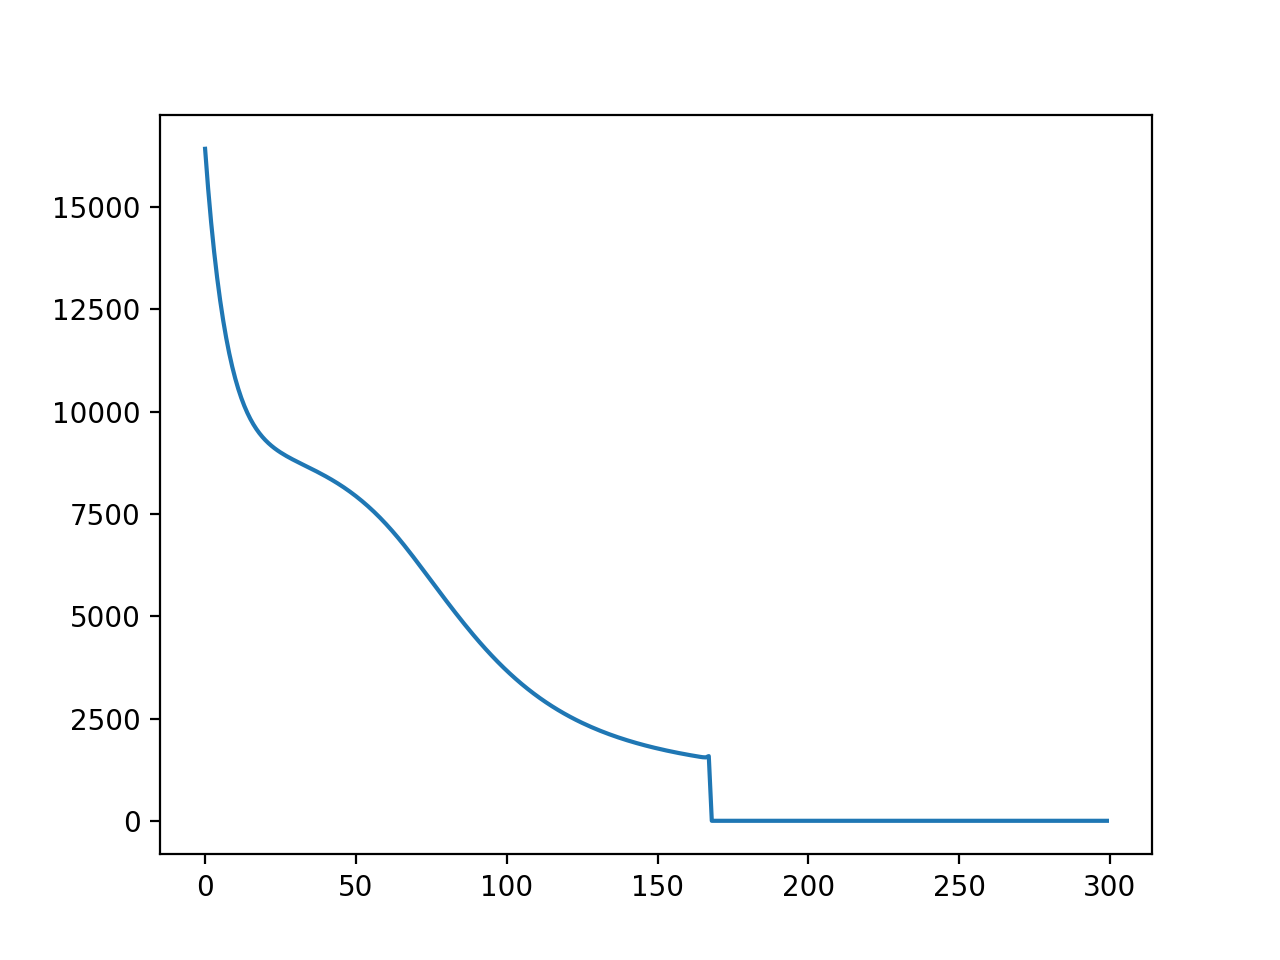

0.0302027750037


In [136]:
#Plots error

x = np.linspace(0,epochs-1,epochs)
plt.figure()
plt.plot(x, allErrors[bestFitIndex])#Plots error progression from best training run out of the five
plt.show()

#prints root mean square error from best training run out of five
print(error(l, allWeights[bestFitIndex], f , allBiases[bestFitIndex])**0.5/numExamples)

In [137]:
bestFitIndex

3

<IPython.core.display.Javascript object>


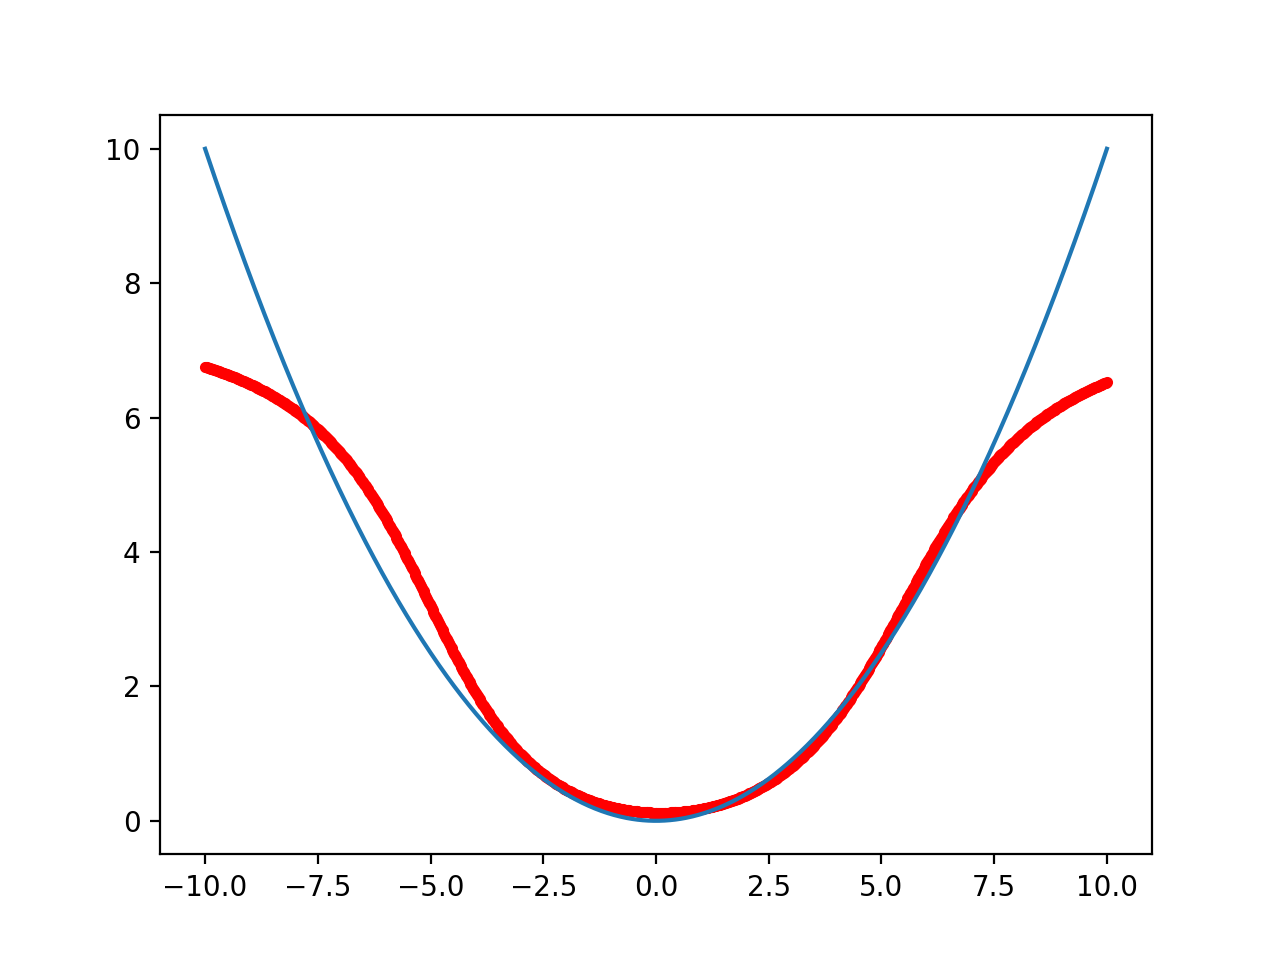

In [138]:
#Plots features vs labels, and best of the five fit function generated by network
p = predict(allWeights[bestFitIndex], f, allBiases[bestFitIndex])
plt.figure()
#plt.plot(np.ravel(f),np.ravel(np.sum(relus,axis = 0)),"b-")
plt.plot(np.ravel(f[0]), np.ravel(p), "r.", f[0], np.ravel(l))
plt.show()

<IPython.core.display.Javascript object>


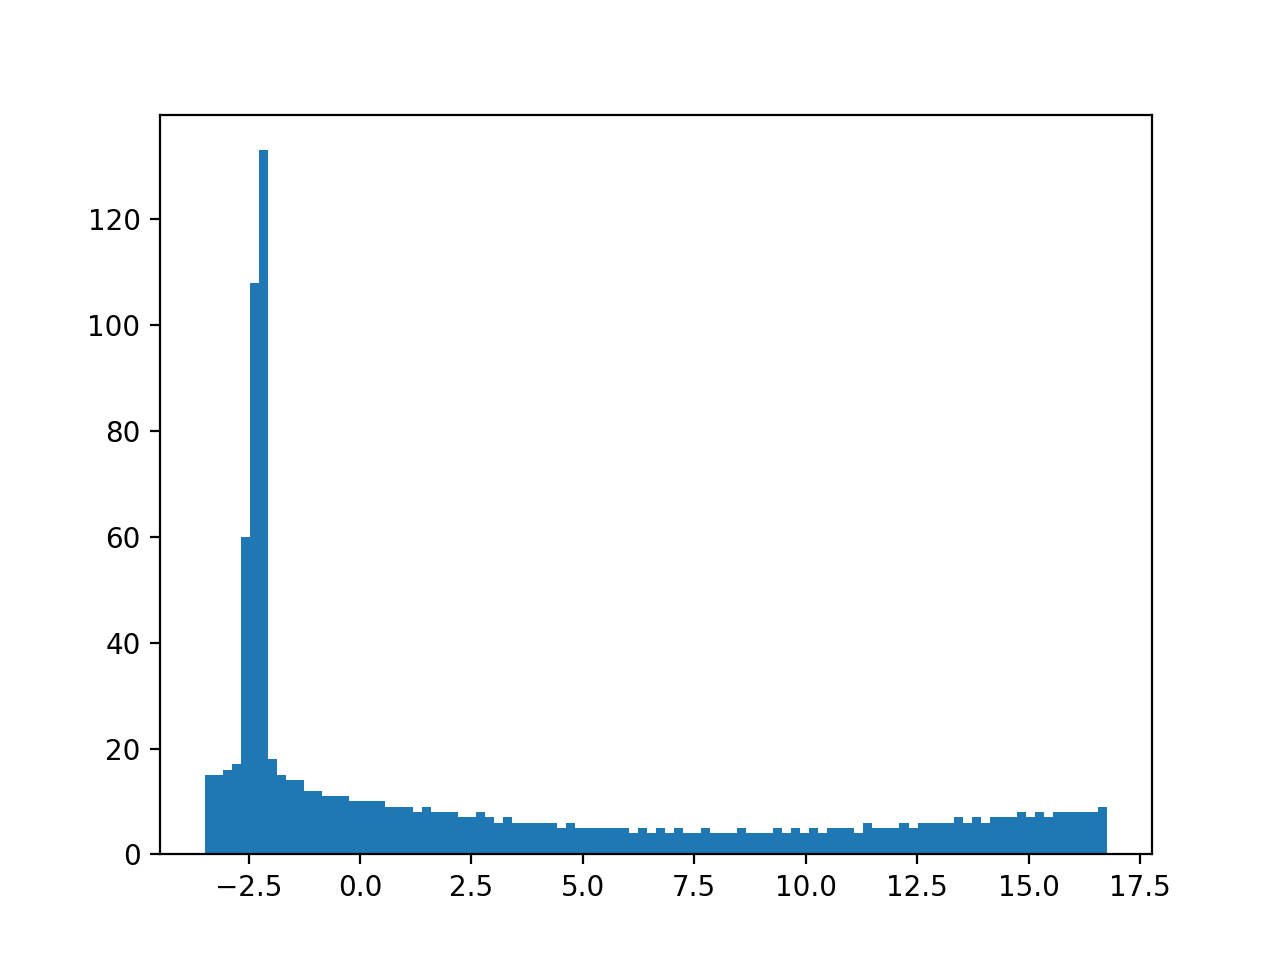

In [139]:
#Histogram describing where the fit function most poorly approximates the real function. 
#Number of times a specific error bracket occures is on X axis, abs(error) is on Y axis.
#In a good fit, this should be clustered toward the left side of the plot.
plt.figure()
plt.hist( ( np.ravel(p)-np.ravel(f) )**1,100)
plt.show()

# One Layer Debugging and Testing Code:

#Assuming just one layer is active, uses weights and biases and creates max functions out of them
relus = np.zeros(w[0].shape)
relus = np.maximum(f*w[0]+b[0][:,None],0)

#Plots all max functions used in the fit
plt.figure()
for i in range(w[0].shape[0]):
    plt.plot(np.ravel(f),np.ravel(relus[i]))
plt.show()

#Plots derivative over epoch. Really only useful when testing a 1 neuron case.

plt.figure()

derivativeXs = range(10,epochs)

pd = np.zeros(len(derivativeXs))
for i in derivativeXs:
    pd[i-10] = derivatives[i][0][0][0]
    
plt.plot(derivativeXs,pd)
plt.show()

In [140]:
#Test Cases. Manually calculated answer, then ran network to verify code was working.

print(w[0])
print(b[0])

print(error(l,w,f,b))
w[0] = np.array([0.5,-0.5,1.4,-1.4])[:,None]
b[0] = np.array([0,0,-8.4375,8.4375])
print(error(l,w,f,b))

b = np.zeros(3,dtype=object)
b[0] = np.zeros(numNodes[0])
b[1] = np.zeros(numNodes[1])
b[2] = np.zeros(numNodes[2])

SSE = error(l, w, f, b)
print(SSE)

#b[2][0] += 4
print(derivative(l, w, f, b)[1][2])
#b[2][0] -= 4

f[0] = 2
l[0] = 4

w[0][0][0] = 4
w[1][0][0] = 5
w[2][0][0] = 6

b[0][0] = 7
b[1][0] = 8
b[2][0] = 9

f = np.array([[1,2,3],[4,5,6]])
l = np.array([1,2,3])

w[0] = np.array([[1,2], [3,4]])
w[1] = np.array([[1,2], [3,4], [5,6]])
w[2] = np.array([1,2,3])

b[0] = np.array([1,2])
b[1] = np.array([3,4,5])
b[2] = np.array([6])

print(error(l,w,f,b))

In [141]:
#Visualization of error function with one weight and one bias
#Next two blocks of code are really only useful with a one neuron network. Results in a 3-D error function
#Difficult to visualize higher dimensional error functions

contourWeightList = np.linspace(-2.0, 2, 200) #Generates a vector of weights 
contourBiasList = np.linspace(-20.0, 10.0, 100)#Generates a vector of biases 
#Creates a meshgrid. Two separate 2-D matrices where only one variable (weights or biases) changes along a certain axis
#Essentially just lots of values to plug into error function and create some sort of shape
meshGridWeights, meshGridBiases = np.meshgrid(contourWeightList, contourBiasList) 

#Saves errors at a given location
errorGrid = np.zeros((100,200))


for cwi in range(200):
    for cbi in range(100):
        #Calculates error using points from meshGrid
        errorGrid[cbi][cwi] = np.sum((np.maximum(f*meshGridWeights[cbi][cwi]+meshGridBiases[cbi][cwi],0)-l)**2)/numExamples

#Creates a contour plot, showing where the local and global minima are
plt.figure()
CS = plt.contour(meshGridWeights,meshGridBiases,errorGrid,100)
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

#Creates a wireframe plot showing what the overall error function looks like
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_wireframe(meshGridWeights,meshGridBiases,errorGrid)
plt.show()